In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

from mpi4py import MPI
from dolfinx import mesh

In [14]:
random_fields = np.load('/data1/jy384/research/Data/DIPDE/gaussian_field_samples.npy')
kappa_samples = np.load('/data1/jy384/research/Data/DIPDE/kappa_samples.npy')

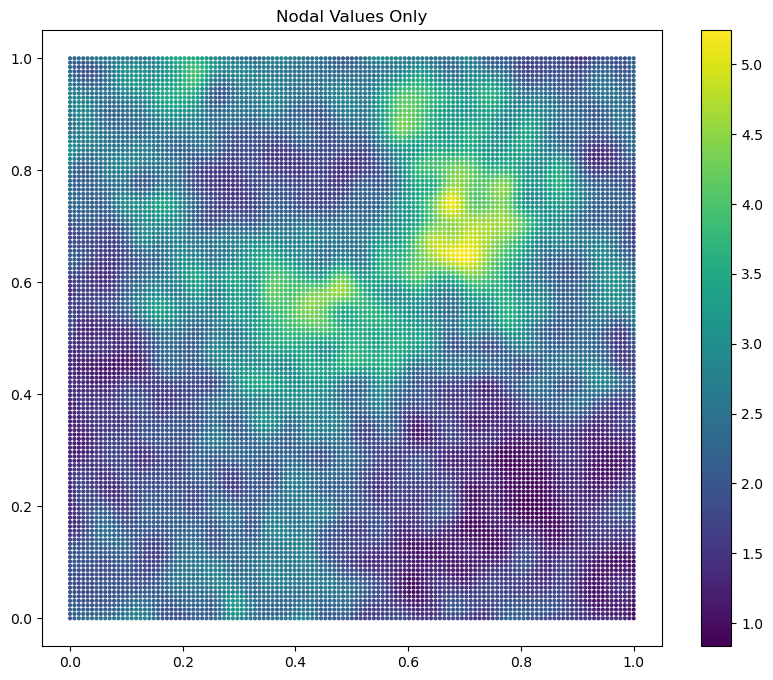

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
from dolfinx.fem import functionspace
from dolfinx import mesh, fem
from dolfinx.mesh import CellType


# Fine grid resolution (128 x 128) and coarse grid resolution (32 x 32)
nx, ny = 128, 128
n_coarse = 32  # 32x32 grid -> 1024 vertices

# Create a triangular mesh on the unit square with fine resolution.
domain = mesh.create_unit_square(MPI.COMM_WORLD, nx, ny, cell_type=CellType.triangle)

# Create facet to cell connectivity required to determine boundary facets
tdim = domain.topology.dim
fdim = tdim - 1
domain.topology.create_connectivity(fdim, tdim)
boundary_facets = mesh.exterior_facet_indices(domain.topology)

# Create a Lagrange P1 function space on the mesh.
V = functionspace(domain, ("Lagrange", 1))

# Reshape the flattened coarse field into a 32x32 grid.
coarse_field = kappa_samples[0].reshape(n_coarse, n_coarse)

# Define the coarse grid coordinates.
x_coarse = np.linspace(0, 1, n_coarse)
y_coarse = np.linspace(0, 1, n_coarse)

# Create an interpolator using the coarse grid data.
interp_func = RegularGridInterpolator((x_coarse, y_coarse), coarse_field, method='cubic')

# Define the function that evaluates the interpolator at given points.
def interpolant(x):
    # x has shape (2, npoints); we transpose to shape (npoints, 2) for the interpolator.
    points = np.array([x[0], x[1]]).T
    return interp_func(points)

# Create the function on the finite element space and interpolate.
kappa = fem.Function(V)
kappa.interpolate(interpolant)

# (Optional) Visualize the interpolated field using a simple contour plot.
# Get the number of locally owned DOFs and the geometric dimension.
# Get the number of locally owned DOFs and the actual geometric dimension
local_size = V.dofmap.index_map.size_local
gdim = 3  # DOLFINx uses 3D coordinates even for 2D domains

# Tabulate the coordinates and reshape using gdim
dof_coords = V.tabulate_dof_coordinates()[: local_size * gdim].reshape((-1, gdim))

# For plotting in 2D, use only the first two columns (x and y)
u_values = kappa.x.array

plt.figure(figsize=(10, 8))
plt.scatter(dof_coords[:, 0], dof_coords[:, 1], c=u_values, 
        #    s=5,  # Smaller point size
           marker='.',  # Use dot markers
           cmap='viridis',
           edgecolors='none')  # Remove point outlines
plt.colorbar()
plt.title("Nodal Values Only")
plt.show()


trame


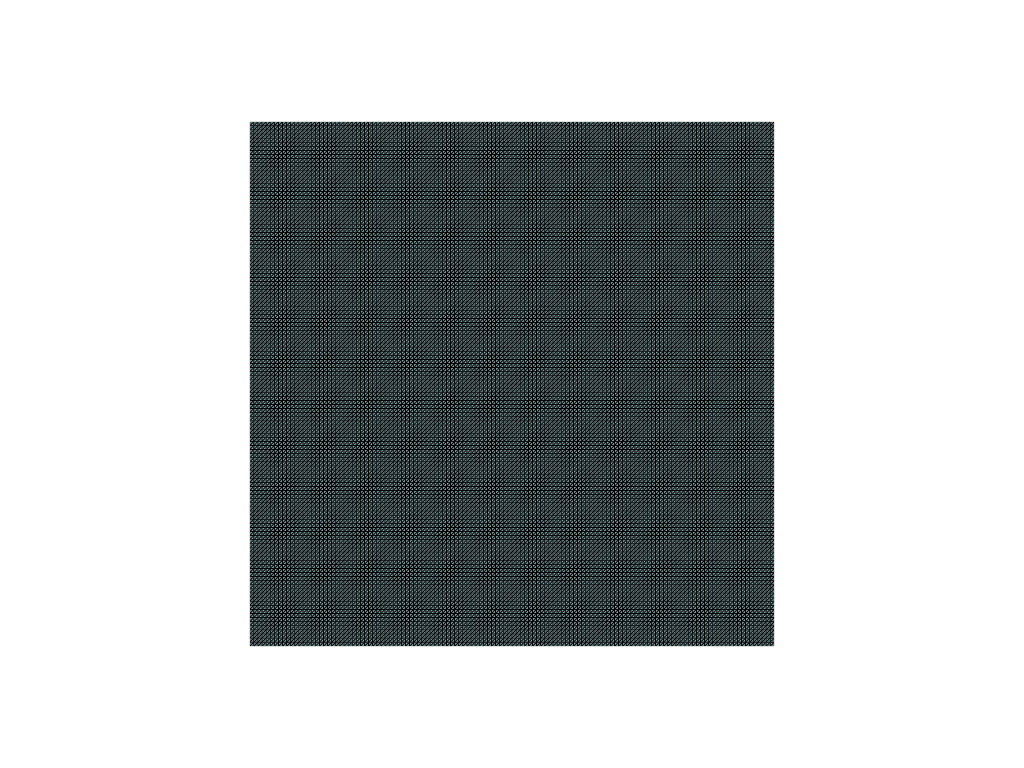

In [16]:
import pyvista
from dolfinx import plot

print(pyvista.global_theme.jupyter_backend)

# Set point visualization mode
pyvista.global_theme.point_size = 1

pyvista.start_xvfb()
domain.topology.create_connectivity(tdim, tdim)

# Create visualization
plotter = pyvista.Plotter()
topology, cell_types, geometry = plot.vtk_mesh(domain, tdim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    figure = plotter.screenshot("fundamentals_mesh.png")


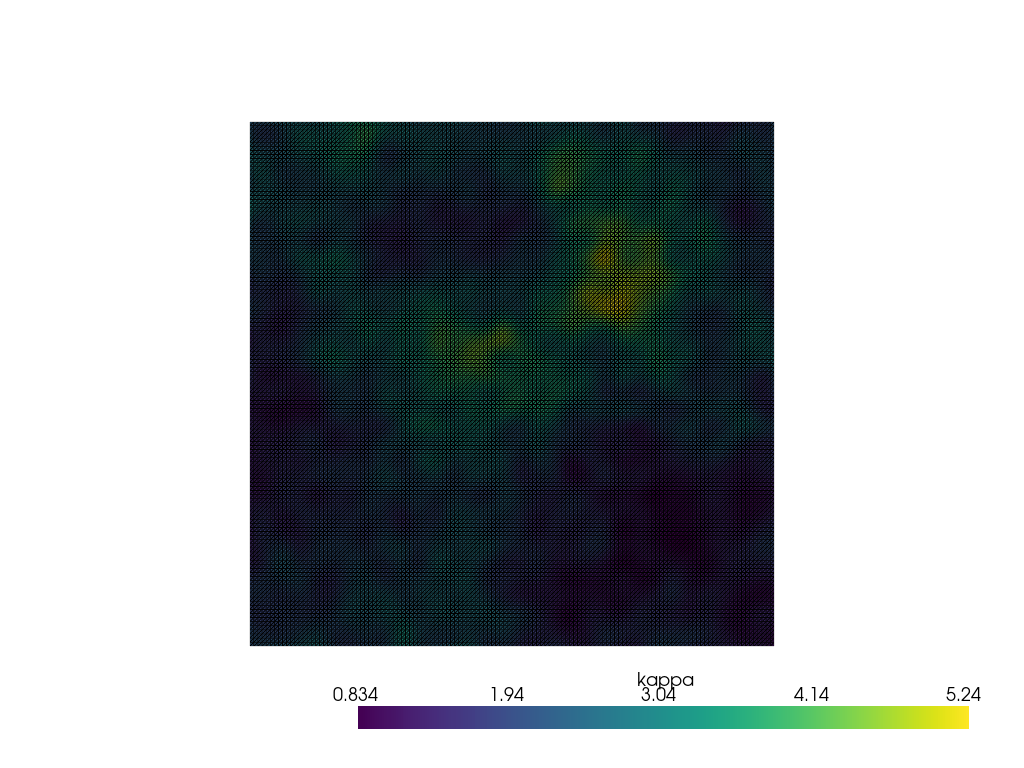

In [17]:
kappa_topology, kappa_cell_types, kappa_geometry = plot.vtk_mesh(V)

kappa_grid = pyvista.UnstructuredGrid(kappa_topology, kappa_cell_types, kappa_geometry)
kappa_grid.point_data["kappa"] = kappa.x.array.real
kappa_grid.set_active_scalars("kappa")
kappa_plotter = pyvista.Plotter()
kappa_plotter.add_mesh(kappa_grid, show_edges=True)
kappa_plotter.view_xy()
if not pyvista.OFF_SCREEN:
    kappa_plotter.show()